In [1]:
import xarray as xr
import hvplot.xarray
import cartopy.crs as crs

In [218]:
ds_codar = xr.open_dataset('https://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USEGC/6km/hourly/RTV/HFRADAR_US_East_and_Gulf_Coast_6km_Resolution_Hourly_RTV_best.ncd')

In [219]:
ds_codar

<xarray.Dataset>
Dimensions:                (lat: 460, lon: 701, nv: 2, time: 87654, time_1: 1)
Coordinates:
  * lat                    (lat) float32 21.74 21.79 21.84 ... 46.39 46.44 46.49
  * lon                    (lon) float32 -97.88 -97.83 -97.77 ... -57.29 -57.23
  * time                   (time) datetime64[ns] 2012-01-01 ... 2022-02-14T19...
    time_run               (time) datetime64[ns] ...
Dimensions without coordinates: nv, time_1
Data variables:
    time_bnds              (time_1, nv) int32 ...
    depth_bnds             (nv) float32 ...
    wgs84                  int8 ...
    processing_parameters  int8 ...
    radial_metadata        int8 ...
    depth                  float32 ...
    time_offset            (time) datetime64[ns] ...
    u                      (time, lat, lon) float32 ...
    v                      (time, lat, lon) float32 ...
    dopx                   (time, lat, lon) float32 ...
    dopy                   (time, lat, lon) float32 ...
    hdop                   (time, lat, lon) float32 ...
    number_of_sites        (time, lat, lon) float32 ...
    number_of_radials      (time, lat, lon) float32 ...
Attributes:
    Conventions:               CF-1.4, ACDD-1.3
    id:                        202202140300siohfruwlsrtvusegc6km
    date_created:              2022-02-14T04:53:58Z
    source:                    surface ocean velocity field from hf-radar
    program:                   Integrated Ocean Observing System (IOOS)
    title:                     Near-Real Time Surface Ocean Velocity, U.S. Ea...
    summary:                   Surface ocean velocities estimated from HF-Rad...
    instrument:                Earth Remote Sensing Instruments, Active Remot...
    keywords:                  Earth Science, Oceans, Sea Surface, Coastal Pr...
    geospatial_lat_min:        21.73596
    geospatial_lat_max:        46.49442
    geospatial_lon_min:        -97.88385
    geospatial_lon_max:        -57.23121
    processing_level:          Near real-time dataset with automated data acq...
    history:                   2022-02-14T03:54:10Z hfrnet rtvMergeData: Savi...
    references:                Terrill, E. et al., 2006. Data Management and ...
    institution:               Coastal Observing Research and Development Cen...
    creator_type:              group
    creator_name:              HFRNet Administrators
    creator_email:             hfrnet.administrators@sio.ucsd.edu
    creator_url:               http://cordc.ucsd.edu/projects/mapping/
    naming_authority:          edu.ucsd.cordc
    standard_name_vocabulary:  CF Standard Name Table, Version 51
    keywords_vocabulary:       Global Change Master Directory (GCMD) Keywords...
    instrument_vocabulary:     Global Change Master Directory (GCMD) Keywords...
    format_version:            1.1.00
    product_version:           2.0.00
    _CoordSysBuilder:          ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:             GRID
    featureType:               GRID
    location:                  Proto fmrc:HFRADAR_US_East_and_Gulf_Coast_6km_...

In [3]:
import pandas as pd
import hvplot.pandas  # noqa
from datetime import timedelta
from datetime import datetime
import numpy as np
df = pd.read_csv("data/sept_cruise/SW21011R_RFP/EventData/DataLogger/Data every 1 min_001.elg")

date_time_strs = df['Date'] + ' ' + df['Time']

df['datetime'] = [datetime.strptime(x, '%m/%d/%Y %H:%M:%S') for x in date_time_strs]
df['utc_dt'] = df['datetime']+ timedelta(minutes=4)
df  = df.set_index('utc_dt')
def dms2dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes/60 + seconds/(60*60);
    if direction == 'W' or direction == 'S':
        dd *= -1
    return dd;

df['lon'] = dms2dd(pd.to_numeric(df['SW-GGA-Long'].astype(str).str[:2]).astype(float), pd.to_numeric(df['SW-GGA-Long'].astype(str).str[2:]),np.array(0), 'W')
df['lat'] = dms2dd(pd.to_numeric(df['SW-GGA-Lat'].astype(str).str[:2]).astype(float), pd.to_numeric(df['SW-GGA-Lat'].astype(str).str[2:]),np.array(0), 'E')

In [248]:
resamp_codar = ds_codar.u[time_step:time_step+1000,:,:].sel( lat=slice(34, 37), lon=slice(-77,-73)).resample(time='6H').mean()

In [255]:
resamp_codar_v = ds_codar.v[time_step:time_step+1000,:,:].sel( lat=slice(34, 37), lon=slice(-77,-73)).resample(time='6H').mean()

In [253]:
resamp_codar.hvplot.quadmesh(
    'lon', 'lat', projection=crs.PlateCarree(), project=True,
    dynamic=True, 
    frame_height=600, clim=(-1,1), cmap='bwr', rasterize=True) * df.loc['2021-09-5 11:00:00':'2021-09-7 13:45:00'].hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.01)

:DynamicMap   [time]
   :Overlay
      .Image.I  :Image   [lon,lat]   (u)
      .Points.I :Points   [lon,lat]

In [256]:
resamp_codar_v.hvplot.quadmesh(
    'lon', 'lat', projection=crs.PlateCarree(), project=True,
    dynamic=True, 
    frame_height=600, clim=(-1,1), cmap='bwr', rasterize=True) * df.loc['2021-09-5 11:00:00':'2021-09-7 13:45:00'].hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.01)

:DynamicMap   [time]
   :Overlay
      .Image.I  :Image   [lon,lat]   (v)
      .Points.I :Points   [lon,lat]

In [241]:
fig, ax = plt.subplots(1,1, figsize=(12,8), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')
time_step = 83700
print(ds_codar.u[time_step].time)
ds_codar.u[time_step:time_step+12,:,:].sel( lat=slice(34, 37), lon=slice(-77,-73)).mean(dim='time', skipna=True).plot(ax=ax)

<xarray.DataArray 'time' ()>
array('2021-09-03T02:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time      datetime64[ns] 2021-09-03T02:00:00
    time_run  datetime64[ns] 2021-09-03T02:00:00
Attributes:
    long_name:            Forecast time for ForecastModelRunCollection
    standard_name:        time
    _CoordinateAxisType:  Time


In [12]:
fn = 'https://www.ncei.noaa.gov/thredds-coastal/dodsC/us_east/us_east_20201218_to_current/20210906/coamps_ncom_useast_u_1_2021090600_00180000.nc'
# fn = 'https://www.ncei.noaa.gov/thredds-coastal/dodsC/us_east/us_east_20201218_to_current/20210903/coamps_ncom_useast_u_1_2021090300_00150000.nc'
# fn = 'https://www.ncei.noaa.gov/thredds-coastal/dodsC/us_east/us_east_20201218_to_current/20210820/coamps_ncom_useast_u_1_2021082000_00120000.nc'

ds = xr.open_dataset(fn)

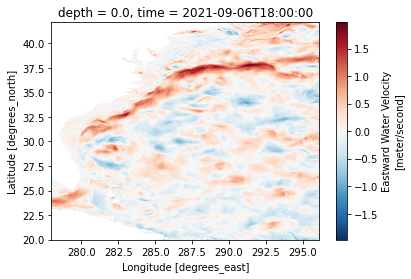

In [13]:
ds.water_u[0,0,:,:].plot()

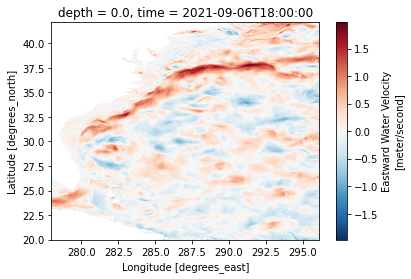

In [120]:
ds.water_u[0,0,:,:].plot()

In [121]:
ds

<xarray.Dataset>
Dimensions:                (depth: 40, lat: 664, lon: 544, time: 1)
Coordinates:
  * lon                    (lon) float64 278.0 278.0 278.1 ... 296.0 296.1 296.1
  * lat                    (lat) float64 20.0 20.03 20.07 ... 42.03 42.06 42.1
  * depth                  (depth) float64 0.0 2.0 4.0 6.0 ... 3e+03 4e+03 5e+03
  * time                   (time) datetime64[ns] 2021-09-06T18:00:00
Data variables:
    tau                    (time) datetime64[ns] ...
    surf_el                (time, lat, lon) float32 ...
    water_u                (time, depth, lat, lon) float32 ...
    water_v                (time, depth, lat, lon) float32 ...
    water_w                (time, depth, lat, lon) float32 ...
    salinity               (time, depth, lat, lon) float32 ...
    water_temp             (time, depth, lat, lon) float32 ...
    surf_atm_press         (time, lat, lon) float32 ...
    surf_wnd_stress_gridx  (time, lat, lon) float32 ...
    surf_wnd_stress_gridy  (time, lat, lon) float32 ...
    surf_roughness         (time, lat, lon) float32 ...
    surf_temp_flux         (time, lat, lon) float32 ...
    surf_solar_flux        (time, lat, lon) float32 ...
Attributes:
    classification_level:            
    distribution_statement:          Approved for public release; distributio...
    downgrade_date:                  not applicable
    classification_authority:        not applicable
    institution:                     not applicable
    Conventions:                     NAVO_netcdf_v1.1
    contact:                         not applicable
    history:                         created: 2021-09-06 07:39:50 -0000
    generating_model:                COAMPS useast_u project
    model_type:                      COAMPS Version 5.3.40
    operational_status:              not applicable
    input_data_source:               not applicable
    source:                          NCOM Version 4.3.42
    time_origin:                     2021-09-06 00:00:00 UTC
    DODS_EXTRA.Unlimited_Dimension:  time

In [122]:
ds.water_temp[0,30,:,:]

<xarray.DataArray 'water_temp' (lat: 664, lon: 544)>
[361216 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 278.0 278.0 278.1 278.1 ... 296.0 296.0 296.1 296.1
  * lat      (lat) float64 20.0 20.03 20.07 20.1 20.13 ... 42.0 42.03 42.06 42.1
    depth    float64 800.0
    time     datetime64[ns] 2021-09-06T18:00:00
Attributes:
    long_name:     Water Temperature
    units:         degC
    NAVO_code:     15
    actual_range:  [ 2.167109 34.042572]
    valid_range:   [-32767  32767]

In [123]:
# ds.water_temp[0,0,:,:].hvplot.quadmesh(
#     'lon', 'lat', projection=crs.PlateCarree(), project=True,
#     dynamic=True, 
#     frame_height=600, clim=(25.5, 29.5), cmap='inferno', rasterize=True) #* df.loc['2021-08-27 11:00:00':'2021-08-29 13:45:00'].hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.01)

In [124]:
ds

<xarray.Dataset>
Dimensions:                (depth: 40, lat: 664, lon: 544, time: 1)
Coordinates:
  * lon                    (lon) float64 278.0 278.0 278.1 ... 296.0 296.1 296.1
  * lat                    (lat) float64 20.0 20.03 20.07 ... 42.03 42.06 42.1
  * depth                  (depth) float64 0.0 2.0 4.0 6.0 ... 3e+03 4e+03 5e+03
  * time                   (time) datetime64[ns] 2021-09-06T18:00:00
Data variables:
    tau                    (time) datetime64[ns] 2021-09-06T18:00:00
    surf_el                (time, lat, lon) float32 ...
    water_u                (time, depth, lat, lon) float32 ...
    water_v                (time, depth, lat, lon) float32 ...
    water_w                (time, depth, lat, lon) float32 ...
    salinity               (time, depth, lat, lon) float32 ...
    water_temp             (time, depth, lat, lon) float32 ...
    surf_atm_press         (time, lat, lon) float32 ...
    surf_wnd_stress_gridx  (time, lat, lon) float32 ...
    surf_wnd_stress_gridy  (time, lat, lon) float32 ...
    surf_roughness         (time, lat, lon) float32 ...
    surf_temp_flux         (time, lat, lon) float32 ...
    surf_solar_flux        (time, lat, lon) float32 ...
Attributes:
    classification_level:            
    distribution_statement:          Approved for public release; distributio...
    downgrade_date:                  not applicable
    classification_authority:        not applicable
    institution:                     not applicable
    Conventions:                     NAVO_netcdf_v1.1
    contact:                         not applicable
    history:                         created: 2021-09-06 07:39:50 -0000
    generating_model:                COAMPS useast_u project
    model_type:                      COAMPS Version 5.3.40
    operational_status:              not applicable
    input_data_source:               not applicable
    source:                          NCOM Version 4.3.42
    time_origin:                     2021-09-06 00:00:00 UTC
    DODS_EXTRA.Unlimited_Dimension:  time

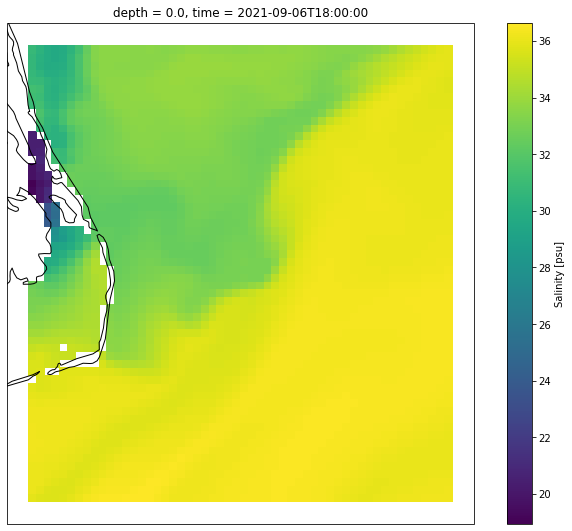

In [125]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(12,8), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')
ds.salinity[0,0,440:498,186:240].plot(ax=ax)

# fig.savefig('sst_sept0619_studypoints.png',dpi=400)
# ax[1].set_title(titles[i] + ' zoom')
fig.tight_layout()
#     fig.savefig('figs/'+titles[i] +'sat_overview.png')
#     plt.close()

# fcm_gdf.plot(ax=ax, markersize=15, column='Chla_Avg', vmin=.1,vmax=.25, cmap='jet')
# plt.savefig('sampling_locations_sept4-9.png',dpi=300)
plt.show()

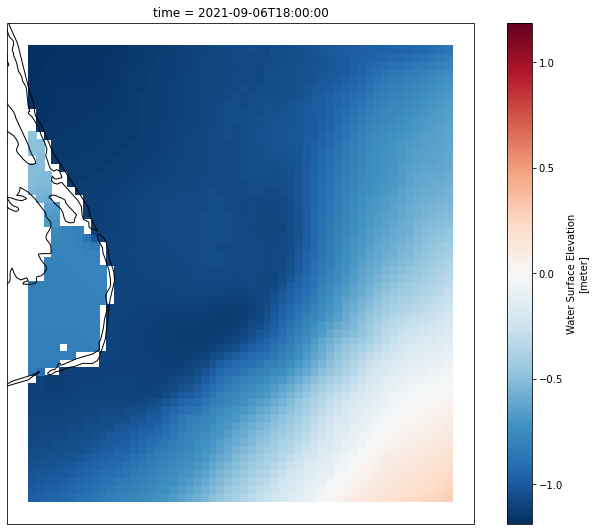

In [126]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(12,8), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')
ds.surf_el[0,440:498,186:240].plot(ax=ax)

# fig.savefig('sst_sept0619_studypoints.png',dpi=400)
# ax[1].set_title(titles[i] + ' zoom')
fig.tight_layout()
#     fig.savefig('figs/'+titles[i] +'sat_overview.png')
#     plt.close()

# fcm_gdf.plot(ax=ax, markersize=15, column='Chla_Avg', vmin=.1,vmax=.25, cmap='jet')
# plt.savefig('sampling_locations_sept4-9.png',dpi=300)
plt.show()

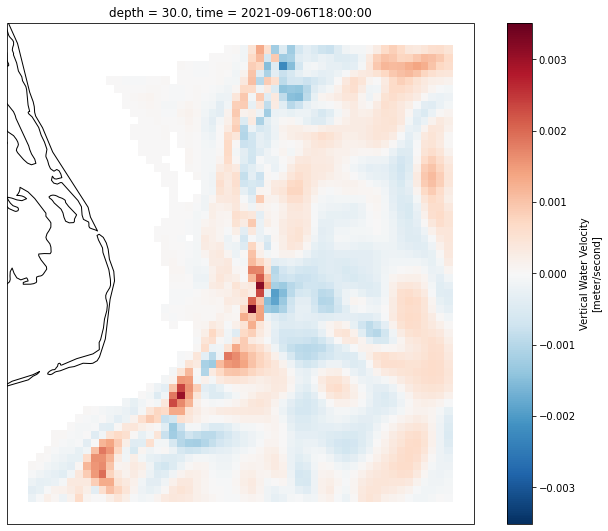

In [127]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(12,8), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')
ds.water_w[0,10,440:498,186:240].plot(ax=ax)

# fig.savefig('sst_sept0619_studypoints.png',dpi=400)
# ax[1].set_title(titles[i] + ' zoom')
fig.tight_layout()
#     fig.savefig('figs/'+titles[i] +'sat_overview.png')
#     plt.close()

# fcm_gdf.plot(ax=ax, markersize=15, column='Chla_Avg', vmin=.1,vmax=.25, cmap='jet')
# plt.savefig('sampling_locations_sept4-9.png',dpi=300)
plt.show()

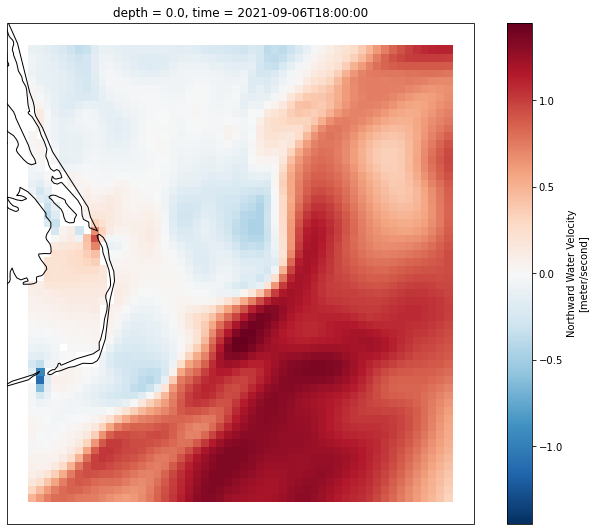

In [128]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(12,8), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')
ds.water_v[0,0,440:498,186:240].plot(ax=ax)

# fig.savefig('sst_sept0619_studypoints.png',dpi=400)
# ax[1].set_title(titles[i] + ' zoom')
fig.tight_layout()
#     fig.savefig('figs/'+titles[i] +'sat_overview.png')
#     plt.close()

# fcm_gdf.plot(ax=ax, markersize=15, column='Chla_Avg', vmin=.1,vmax=.25, cmap='jet')
# plt.savefig('sampling_locations_sept4-9.png',dpi=300)
plt.show()

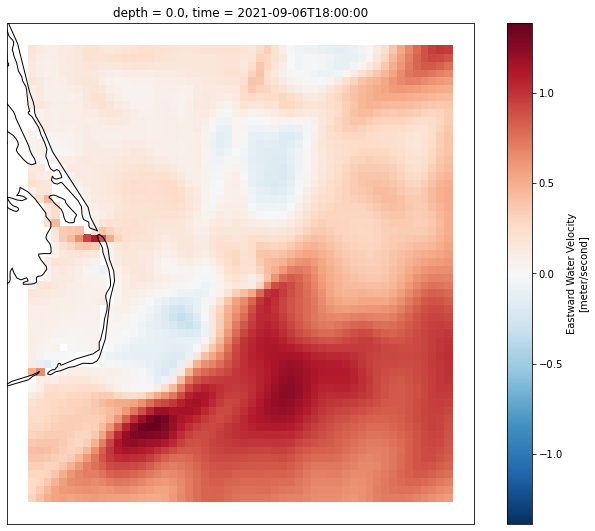

In [129]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(12,8), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')
ds.water_u[0,0,440:498,186:240].plot(ax=ax)

# fig.savefig('sst_sept0619_studypoints.png',dpi=400)
# ax[1].set_title(titles[i] + ' zoom')
fig.tight_layout()
#     fig.savefig('figs/'+titles[i] +'sat_overview.png')
#     plt.close()

# fcm_gdf.plot(ax=ax, markersize=15, column='Chla_Avg', vmin=.1,vmax=.25, cmap='jet')
# plt.savefig('sampling_locations_sept4-9.png',dpi=300)
plt.show()

In [17]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

In [18]:
day_start_times = ['2021-09-5 13:00:00', '2021-09-5 18:15:00', '2021-09-6 12:30:00', '2021-09-6 16:45:00',  '2021-09-7 12:10:00']
day_end_times = ['2021-09-5 17:30:00','2021-09-5 20:30:00',  '2021-09-6 15:00:00', '2021-09-6 19:20:00', '2021-09-7 15:30:00']

dfs = []
for i in range(len(day_start_times)):
    dfs.append(gdf.loc[day_start_times[i]:day_end_times[i]])
df_subset = pd.concat(dfs)

In [28]:
ds

<xarray.Dataset>
Dimensions:                (depth: 40, lat: 664, lon: 544, time: 1)
Coordinates:
  * lon                    (lon) float64 278.0 278.0 278.1 ... 296.0 296.1 296.1
  * lat                    (lat) float64 20.0 20.03 20.07 ... 42.03 42.06 42.1
  * depth                  (depth) float64 0.0 2.0 4.0 6.0 ... 3e+03 4e+03 5e+03
  * time                   (time) datetime64[ns] 2021-09-06T18:00:00
Data variables:
    tau                    (time) datetime64[ns] ...
    surf_el                (time, lat, lon) float32 ...
    water_u                (time, depth, lat, lon) float32 ...
    water_v                (time, depth, lat, lon) float32 ...
    water_w                (time, depth, lat, lon) float32 ...
    salinity               (time, depth, lat, lon) float32 ...
    water_temp             (time, depth, lat, lon) float32 ...
    surf_atm_press         (time, lat, lon) float32 ...
    surf_wnd_stress_gridx  (time, lat, lon) float32 ...
    surf_wnd_stress_gridy  (time, lat, lon) float32 ...
    surf_roughness         (time, lat, lon) float32 ...
    surf_temp_flux         (time, lat, lon) float32 ...
    surf_solar_flux        (time, lat, lon) float32 ...
Attributes:
    classification_level:            
    distribution_statement:          Approved for public release; distributio...
    downgrade_date:                  not applicable
    classification_authority:        not applicable
    institution:                     not applicable
    Conventions:                     NAVO_netcdf_v1.1
    contact:                         not applicable
    history:                         created: 2021-09-06 07:39:50 -0000
    generating_model:                COAMPS useast_u project
    model_type:                      COAMPS Version 5.3.40
    operational_status:              not applicable
    input_data_source:               not applicable
    source:                          NCOM Version 4.3.42
    time_origin:                     2021-09-06 00:00:00 UTC
    DODS_EXTRA.Unlimited_Dimension:  time

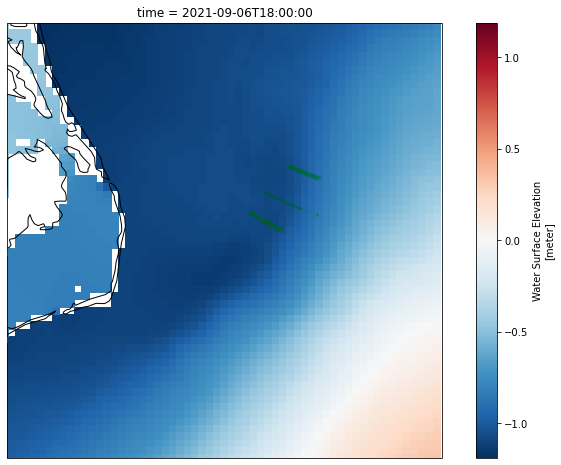

In [50]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(12,8), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')
ax.set_ylim(34.52999878,36.50999832)
ax.set_xlim(-75.98999786,-74.01000214)
ds.surf_el[0,430:498,176:240].plot(ax=ax)
df_subset.loc['2021-09-5 11:00:00':'2021-09-7 15:30:00'].plot(ax=ax, markersize=2, color='green', alpha=.05)
# fig.savefig('ncom_sst_sept0618.png',dpi=400)
# ax[1].set_title(titles[i] + ' zoom')
# fig.tight_layout()
#     fig.savefig('figs/'+titles[i] +'sat_overview.png')
#     plt.close()

# fcm_gdf.plot(ax=ax, markersize=15, column='Chla_Avg', vmin=.1,vmax=.25, cmap='jet')
# plt.savefig('sampling_locations_sept4-9.png',dpi=300)
plt.show()

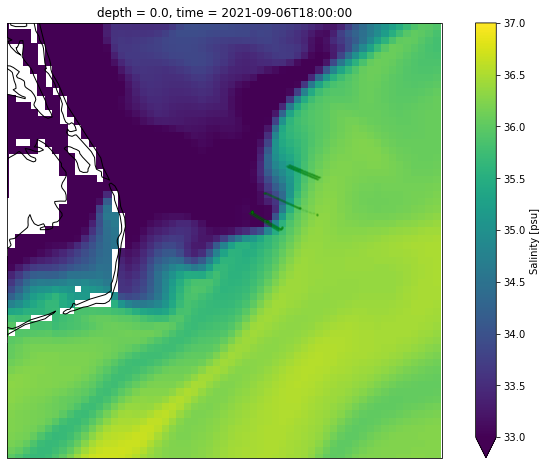

In [48]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(12,8), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')
ax.set_ylim(34.52999878,36.50999832)
ax.set_xlim(-75.98999786,-74.01000214)
ds.salinity[0,0,430:498,176:240].plot(ax=ax,vmin=33,vmax=37)
df_subset.loc['2021-09-5 11:00:00':'2021-09-7 15:30:00'].plot(ax=ax, markersize=2, color='green', alpha=.05)
# fig.savefig('ncom_sst_sept0618.png',dpi=400)
# ax[1].set_title(titles[i] + ' zoom')
# fig.tight_layout()
#     fig.savefig('figs/'+titles[i] +'sat_overview.png')
#     plt.close()

# fcm_gdf.plot(ax=ax, markersize=15, column='Chla_Avg', vmin=.1,vmax=.25, cmap='jet')
# plt.savefig('sampling_locations_sept4-9.png',dpi=300)
plt.show()

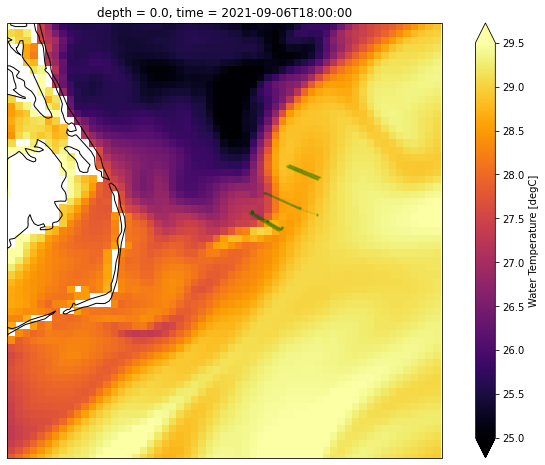

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(12,8), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')
ax.set_ylim(34.52999878,36.50999832)
ax.set_xlim(-75.98999786,-74.01000214)
ds.water_temp[0,0,430:498,176:240].plot(ax=ax, vmin=25, vmax=29.5, cmap='inferno')
df_subset.loc['2021-09-5 11:00:00':'2021-09-7 15:30:00'].plot(ax=ax, markersize=2, color='green', alpha=.05)
# fig.savefig('ncom_sst_sept0618.png',dpi=400)
# ax[1].set_title(titles[i] + ' zoom')
# fig.tight_layout()
#     fig.savefig('figs/'+titles[i] +'sat_overview.png')
#     plt.close()

# fcm_gdf.plot(ax=ax, markersize=15, column='Chla_Avg', vmin=.1,vmax=.25, cmap='jet')
# plt.savefig('sampling_locations_sept4-9.png',dpi=300)
plt.show()

In [140]:
ds.water_temp[0,0,:,:].hvplot.quadmesh(
    'lon', 'lat', projection=crs.PlateCarree(), project=True,
    dynamic=True, 
    frame_height=600, clim=(24,31),cmap='inferno', rasterize=True) #* df.loc['2021-08-27 11:00:00':'2021-08-29 13:45:00'].hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.01)

:DynamicMap   []
   :Image   [lon,lat]   (water_temp)